### Анализ случаев мошенничества в страховании 
- Начать с разведочного (первичного) анализа данных. Визуализируйте датасеты. Поищите явные “более мошеннические” сегменты.
- Построить различные модели, которые будут предсказывать вероятность мошеннического случая (переменную `bad`) на различных классификаторах
- Сравнить результаты градиентного бустинга деревьев с некоторыми параметрами (обсудим в следующий раз как их выбирать) и логистической регрессией (только не забудьте данные нормировать или применять, например, `QuantileTransformer`).
- Попробовать разные способы обработки категориальных признаков (заодно можете сравнить `lightgbm` и `catboost`)
- Объяснить важности признаков. Рекомендую библиотеку http://eli5.readthedocs.io/en/latest/
- Попробовать описать сегменты, где же мошенничают.
- Подумать над вопросом, как лучше свой результат донести менеджеру банкира?

#### Разведочный (первичный) анализ данных.

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
plt.style.use('bmh')

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 400)

%matplotlib inline

In [191]:
file = pd.read_csv("Data\Data_AlfaInsurance_170918.csv", sep=';')

In [192]:
file.head()

,claim_id,Event_type,Period_EvCl,Period_StEv,Policy_agent_cat,Owner_type,FLAG_Owner_bl,Insurer_type,FLAG_Insurer_bl,Policy_KBM,Policy_KS,Policy_KT,Policy_KVS,FLAG_Policy_KO,FLAG_Policy_KP,FLAG_Policy_KPR,FLAG_Policy_type,VEH_age,VEH_aim_use,VEH_capacity_type,VEH_model,VEH_type_name,FLAG_bad_region,FLAG_dsago,FLAG_prolong,Owner_region,Sales_channel,Policy_loss_count,Damage_count,bad,Claim_type,FLAG_trial
0,6091/133/00060/17,Классика,196,292,"0,060013984565045",Юридическое Лицо,0,Юридическое Лицо,0,"0,5",1,"1,4",1,1,1,0,0,6.0,Личные,3.0,ДРУГОЕ ТС ДРУГОЕ ТС ЛЕГКОВОЙ,Легковой,0,0,1,Пензенская область,Собственные продажи,0,1,0,0,0
1,8023/PVU/00265/17,ПВУ СП,59,361,NaN,Физическое Лицо,0,Физическое Лицо,0,1,1,1,1,0,1,0,0,18.0,Личные,5.0,NISSAN PRIMERA,Легковой,1,0,0,Ростовская область,Агенты и РБ,0,1,0,1,1
2,4392/PVU/01330/17,ПВУ СП,27,345,"0,072320678732599",Физическое Лицо,0,Физическое Лицо,0,1,1,"1,8",1,0,1,0,0,8.0,Личные,4.0,OPEL ASTRA,Легковой,0,0,1,Свердловская область,Фронт-офис,0,1,0,0,0
3,0890/PVU/01462/17,ПВУ СП,5,359,"0,079869875190784",Юридическое Лицо,0,Юридическое Лицо,0,1,1,2,1,1,1,0,0,4.0,Личные,5.0,PEUGEOT 308,Легковой,0,0,0,Москва,Агенты и РБ,0,1,0,0,0
4,5641/133/00703/17,Классика,18,337,"0,11915094933231",Физическое Лицо,1,Физическое Лицо,1,1,"0,7","1,7",1,1,1,0,1,3.0,Личные,3.0,RENAULT LOGAN,Легковой,0,0,0,Новосибирская область,Фронт-офис,2,1,0,0,0


Разабьем Event_type на бинарные признаки

In [193]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8519 entries, 0 to 8518
Data columns (total 32 columns):
claim_id             8519 non-null object
Event_type           8519 non-null object
Period_EvCl          8519 non-null int64
Period_StEv          8519 non-null int64
Policy_agent_cat     8413 non-null object
Owner_type           8519 non-null object
FLAG_Owner_bl        8519 non-null int64
Insurer_type         8519 non-null object
FLAG_Insurer_bl      8519 non-null int64
Policy_KBM           8519 non-null object
Policy_KS            8519 non-null object
Policy_KT            8519 non-null object
Policy_KVS           8519 non-null object
FLAG_Policy_KO       8519 non-null int64
FLAG_Policy_KP       8519 non-null int64
FLAG_Policy_KPR      8519 non-null int64
FLAG_Policy_type     8519 non-null int64
VEH_age              8518 non-null float64
VEH_aim_use          8519 non-null object
VEH_capacity_type    8518 non-null float64
VEH_model            8519 non-null object
VEH_type_name    

Отобразим количество пропущеной информации

In [206]:
total = file.isnull().sum()
null_rows = file.isnull().any(axis = 1)
total_bad = file[file.bad == 1].isnull().sum()
missing_data = pd.concat([total, total_bad], axis=1, keys=['Total', 'Total_bad'])
missing_data[missing_data.Total > 0].sort_values(by= "Total",ascending=False).plot(kind="bar")
print("Максимум пустых значений в столбце: ",total.max())
print("Количество пустых записей: ",null_rows.sum())

TypeError: Empty 'DataFrame': no numeric data to plot

Надо что-то делать с пропущеной инфой, решаю удалить записи, в которых присутствует NaN

In [205]:
file = file.drop(file[file.isnull().any(axis = 1) == True].index)
file.isnull().sum().max()

0

bad                               0  1
Owner_region                          
Красноярский край                49  0
Курганская область               41  0
Воронежская область              26  0
Брянская область                 16  0
Республика Бурятия               14  0
Ямало-Ненецкий автономный округ  14  0
Томская область                  12  0
Белгородская область              8  0
Республика Марий Эл               8  0
Республика Саха (Якутия)          7  0
Амурская область                  5  0
Владимирская область              5  0
Костромская область               3  0
город Севастополь                 3  0
Республика Хакассия               2  0
Ненецкий автономный округ         1  0
Республика Тыва                   1  0
Магаданская область               1  0
нет                               1  0


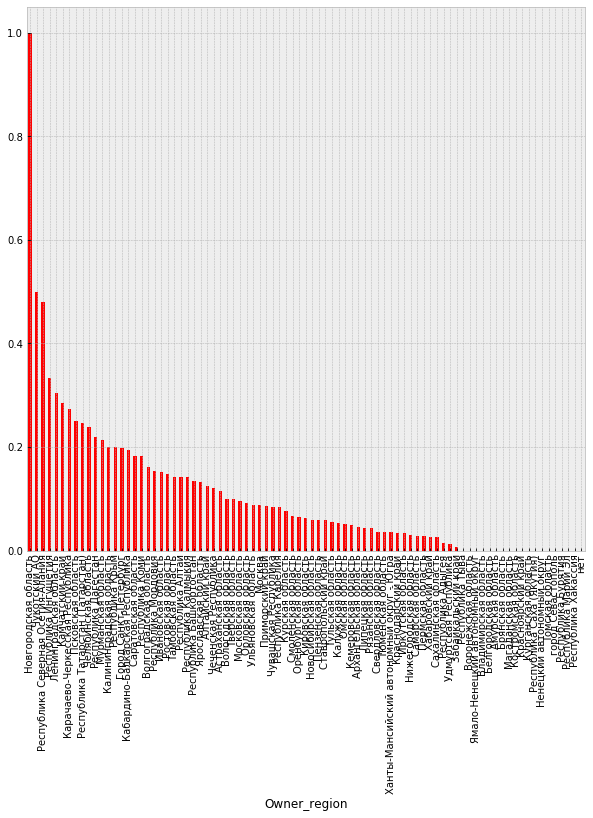

In [279]:
bad = pd.crosstab(file.Owner_region, file.bad)[1]
all = pd.crosstab(file.Owner_region, file.bad).sum(axis=1)
print(pd.crosstab(file.Owner_region, file.bad)[(bad/all)==0].sort_values(by=0, ascending=False))
(bad/all).sort_values(ascending=False).plot(kind="bar", figsize=(10, 10), color='r')

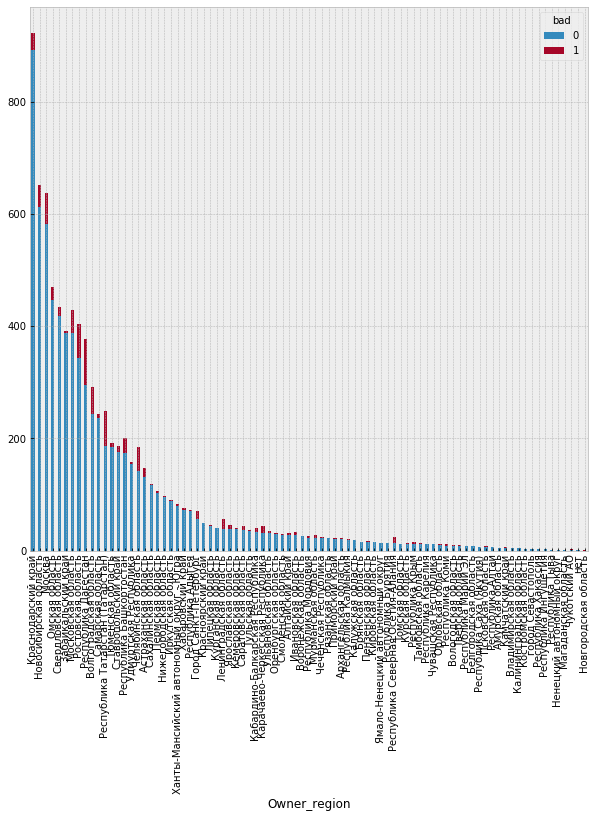

In [284]:
pd.crosstab(file.Owner_region, file.bad).sort_values(by= 0,ascending=False).plot(kind="bar", stacked=True, figsize=(10, 10))

In [93]:
car_group = file.groupby('VEH_model')
car_group.

VEH_model
ACURA MDX                  1
ACURA RDX                  1
AUDI 100                   6
AUDI 80                    6
AUDI 90                    1
AUDI A1                    1
AUDI A2                    1
AUDI A3                    9
AUDI A4                   37
AUDI A5                   14
AUDI A6                   57
AUDI A6 ALLROAD            1
AUDI A7                    7
AUDI A8                   17
AUDI Q3                   10
AUDI Q5                   13
AUDI Q7                   16
AUDI QUATTRO               1
AUDI RS6                   1
AUDI RS7                   1
AUDI S8                    2
AUDI TT                    1
BENTLEY CONTINENTAL        1
BENTLEY CONTINENTAL GT     3
BMW 116                    5
BMW 118                    4
BMW 120                    1
BMW 2 SERIES               1
BMW 316                    7
BMW 318                   13
                          ..
МАЗ 543302                 1
МАЗ 544020                 1
МАЗ 544069                 1
МАЗ 

In [208]:
f_num = file.select_dtypes(include = ['float64', 'int64'])
f_num
f_num.head()

,Period_EvCl,Period_StEv,FLAG_Owner_bl,FLAG_Insurer_bl,FLAG_Policy_KO,FLAG_Policy_KP,FLAG_Policy_KPR,FLAG_Policy_type,VEH_age,VEH_capacity_type,FLAG_bad_region,FLAG_dsago,FLAG_prolong,Policy_loss_count,Damage_count,bad,Claim_type,FLAG_trial
2,27,345,0,0,0,1,0,0,8.0,4.0,0,0,1,0,1,0,0,0
3,5,359,0,0,1,1,0,0,4.0,5.0,0,0,0,0,1,0,0,0
4,18,337,1,1,1,1,0,1,3.0,3.0,0,0,0,2,1,0,0,0
5,16,325,0,0,0,1,0,1,3.0,4.0,0,0,0,0,1,0,1,0
6,7,310,0,0,1,1,0,0,4.0,4.0,0,0,1,0,1,0,1,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001C2A91D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001BAF26D8>]], dtype=object)

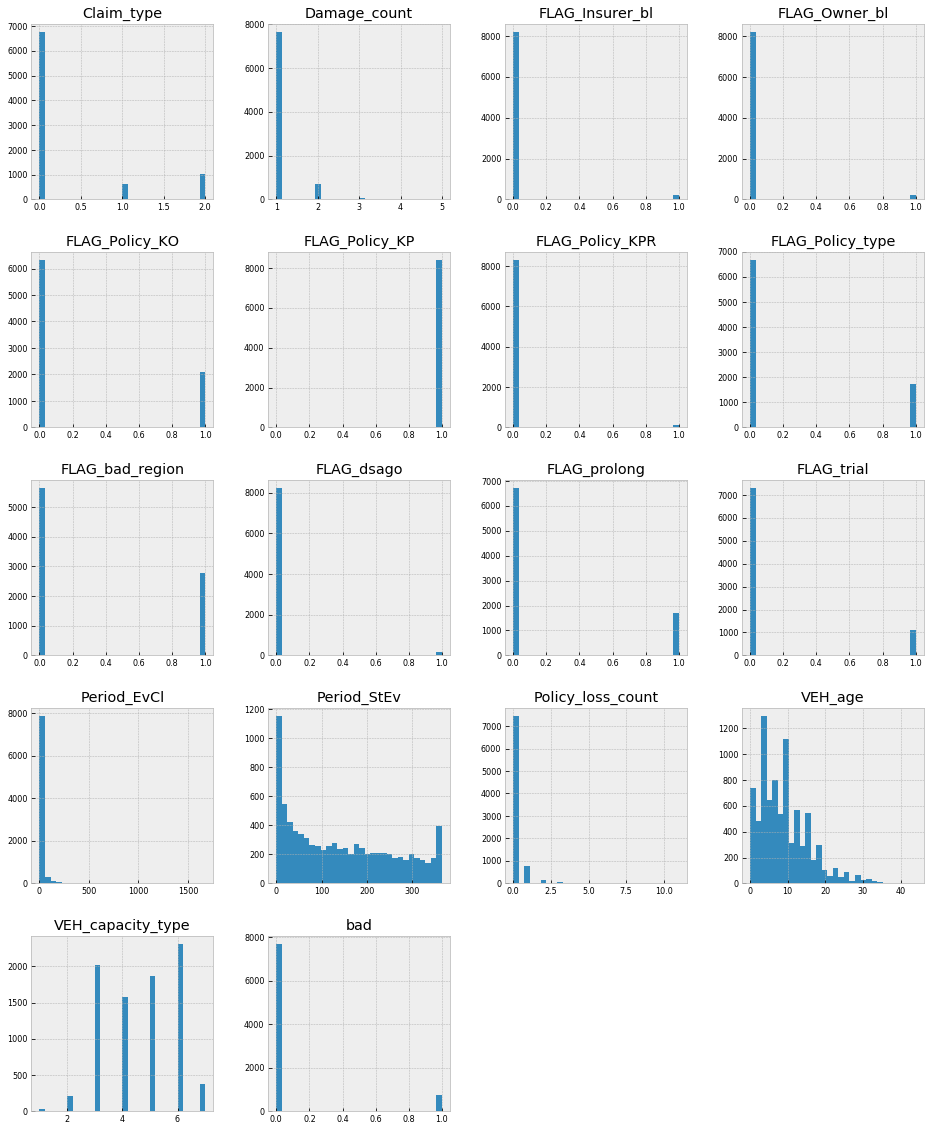

In [210]:
f_num.hist(figsize=(16, 20), bins=30, xlabelsize=8, ylabelsize=8)

In [211]:
#determine the unique genres
types = file.Event_type.unique()

#make a column for each genre
for _type in types:
    file[_type] =  _type == file.Event_type
         
file.head()

,claim_id,Event_type,Period_EvCl,Period_StEv,Policy_agent_cat,Owner_type,FLAG_Owner_bl,Insurer_type,FLAG_Insurer_bl,Policy_KBM,Policy_KS,Policy_KT,Policy_KVS,FLAG_Policy_KO,FLAG_Policy_KP,FLAG_Policy_KPR,FLAG_Policy_type,VEH_age,VEH_aim_use,VEH_capacity_type,VEH_model,VEH_type_name,FLAG_bad_region,FLAG_dsago,FLAG_prolong,Owner_region,Sales_channel,Policy_loss_count,Damage_count,bad,Claim_type,FLAG_trial,ПВУ СП,Классика
2,4392/PVU/01330/17,ПВУ СП,27,345,"0,072320678732599",Физическое Лицо,0,Физическое Лицо,0,1,1,"1,8",1,0,1,0,0,8.0,Личные,4.0,OPEL ASTRA,Легковой,0,0,1,Свердловская область,Фронт-офис,0,1,0,0,0,True,False
3,0890/PVU/01462/17,ПВУ СП,5,359,"0,079869875190784",Юридическое Лицо,0,Юридическое Лицо,0,1,1,2,1,1,1,0,0,4.0,Личные,5.0,PEUGEOT 308,Легковой,0,0,0,Москва,Агенты и РБ,0,1,0,0,0,True,False
4,5641/133/00703/17,Классика,18,337,"0,11915094933231",Физическое Лицо,1,Физическое Лицо,1,1,"0,7","1,7",1,1,1,0,1,3.0,Личные,3.0,RENAULT LOGAN,Легковой,0,0,0,Новосибирская область,Фронт-офис,2,1,0,0,0,False,True
5,8712/PVU/00086/17,ПВУ СП,16,325,"0,048746077092038",Физическое Лицо,0,Физическое Лицо,0,"0,95",1,"1,3",1,0,1,0,1,3.0,Личные,4.0,SKODA YETI,Легковой,0,0,0,Красноярский край,Автодилеры,0,1,0,1,0,True,False
6,4891/PVU/00041/17,ПВУ СП,7,310,"0,019079802125969",Юридическое Лицо,0,Юридическое Лицо,0,"0,85",1,"1,3",1,1,1,0,0,4.0,Прочие,4.0,ДРУГОЕ ТС ДРУГОЕ ТС ЛЕГКОВОЙ,Легковой,0,0,1,Республика Бурятия,ДКК,0,1,0,1,0,True,False


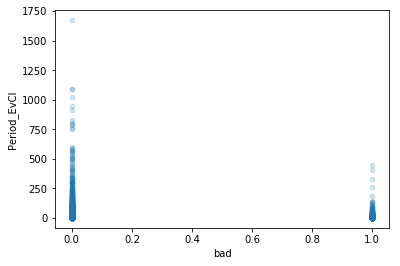

In [69]:
#scatter plot grlivarea/saleprice
var = 'Period_EvCl'
data = pd.concat([file['bad'], file[var]], axis=1)
data.plot.scatter(x='bad', y=var , alpha = 0.2);

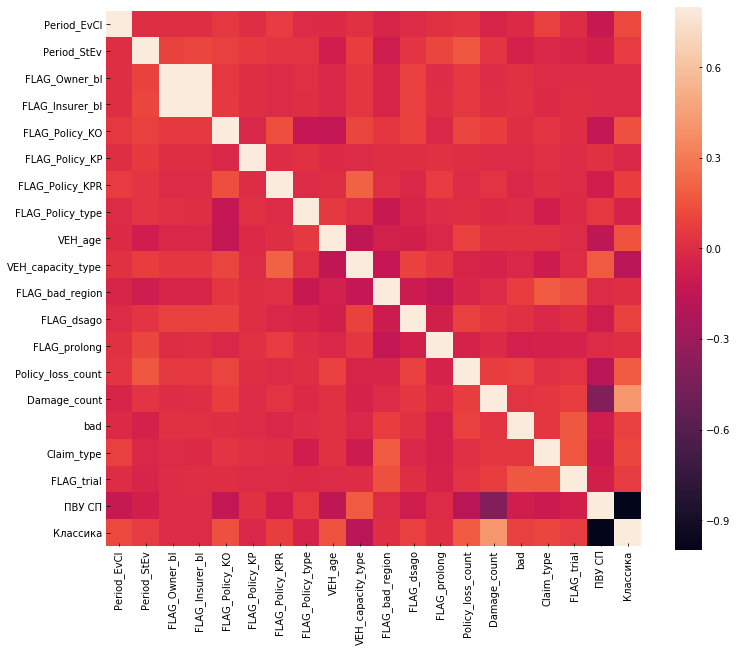

In [212]:
corrmat = file.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, vmax=.8, square=True);

In [73]:
file.columns

Index(['claim_id', 'Event_type', 'Period_EvCl', 'Period_StEv', 'Policy_agent_cat', 'Owner_type', 'FLAG_Owner_bl', 'Insurer_type', 'FLAG_Insurer_bl', 'Policy_KBM', 'Policy_KS', 'Policy_KT',
       'Policy_KVS', 'FLAG_Policy_KO', 'FLAG_Policy_KP', 'FLAG_Policy_KPR', 'FLAG_Policy_type', 'VEH_age', 'VEH_aim_use', 'VEH_capacity_type', 'VEH_model', 'VEH_type_name', 'FLAG_bad_region',
       'FLAG_dsago', 'FLAG_prolong', 'Owner_region', 'Sales_channel', 'Policy_loss_count', 'Damage_count', 'bad', 'Claim_type', 'FLAG_trial', 'Классика', 'ПВУ СП'],
      dtype='object')